In [98]:
import sys
# print(sys.executable)
import os
import json
from PIL import Image
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.ops as ops
import math
import random
YT_ROOTS = [
    "C:\\Users\\18438\\Downloads\\TLD-YT-part1",
    "C:\\Users\\18438\\Downloads\\TLD-YT-part2"
]

def extract_bbox_from_points(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    return [x1, y1, x2 - x1, y2 - y1]  # x, y, w, h
# brake_on, brake_off, left_signal, right_signal, hazard, off
def normalize_label(shape):
    raw = shape["label"]

    if "BrakeOn" in raw:
        return "brake_on"
    if "BrakeOff" in raw:
        return "brake_off"

    ts = shape.get("attributes", {}).get("turn_signal", "")
    if ts == "left":
        return "left_signal"
    if ts == "right":
        return "right_signal"
    if ts == "hazard":
        return "hazard"
    if ts == "off":
        return "off"
    print(ts)
    return "unknown"

def load_yt_dataset(root_dirs):
    samples = []

    for root in root_dirs:
        for dirpath, _, filenames in os.walk(root):
            jpg_files = [f for f in filenames if f.lower().endswith(".jpg")]

            for jpg in jpg_files:
                img_path = os.path.join(dirpath, jpg)
                json_path = os.path.join(dirpath, jpg.replace(".jpg", ".json"))

                if not os.path.exists(json_path):
                    # skip images without annotations
                    continue

                try:
                    with open(json_path, "r") as f:
                        ann = json.load(f)
                except:
                    # skip corrupted jsons
                    continue

                objects = []
                for shape in ann.get("shapes", []):
                    bbox = extract_bbox_from_points(shape["points"])
                    label = normalize_label(shape)
                    objects.append({"bbox": bbox, "label": label})

                samples.append({
                    "image_path": img_path,
                    "objects": objects
                })
                if (len(samples) % 1000 == 0):
                    print(f"Loaded {len(samples)} samples out of 111800")

    return samples

In [4]:
print('starting to load YT dataset...')
samples = load_yt_dataset(YT_ROOTS)
print("Total samples:", len(samples))


starting to load YT dataset...
Loaded 1000 samples...
Loaded 2000 samples...
Loaded 3000 samples...
Loaded 4000 samples...
Loaded 5000 samples...
Loaded 6000 samples...
Loaded 7000 samples...
Loaded 8000 samples...
Loaded 9000 samples...
Loaded 10000 samples...
Loaded 11000 samples...
Loaded 12000 samples...
Loaded 13000 samples...
Loaded 14000 samples...
Loaded 15000 samples...
Loaded 16000 samples...
Loaded 17000 samples...
Loaded 18000 samples...
Loaded 19000 samples...
Loaded 20000 samples...
Loaded 21000 samples...
Loaded 22000 samples...
Loaded 23000 samples...
Loaded 24000 samples...
Loaded 25000 samples...
Loaded 26000 samples...
Loaded 27000 samples...
Loaded 28000 samples...
Loaded 29000 samples...
Loaded 30000 samples...
Loaded 31000 samples...
Loaded 32000 samples...
Loaded 33000 samples...
Loaded 34000 samples...
Loaded 35000 samples...
Loaded 36000 samples...
Loaded 37000 samples...
Loaded 38000 samples...
Loaded 39000 samples...
Loaded 40000 samples...
Loaded 41000 sampl

In [99]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
text_queries = [
    "vehicle",
    "car tail light",
    "brake light",
    "left turn signal",
    "right turn signal",
    "car hazard lights"
]

In [101]:
def visualize_prediction(img_path, ann_objects, draw=False):
    img = Image.open(img_path).convert("RGB")
    width, height = img.size

    inputs = processor(text=text_queries, images=img, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([(height, width)])
    result = processor.post_process_grounded_object_detection(
        outputs=outputs,
        target_sizes=target_sizes,
        threshold=0.1,
        text_labels=[text_queries],
    )[0]

    boxes, scores, labels = result["boxes"], result["scores"], result["text_labels"]
    if draw:
        fig, ax = plt.subplots(1, figsize=(12, 7))
        ax.imshow(img)

        # truth
        for obj in ann_objects:
            x, y, w, h = obj["bbox"]
            ax.add_patch(patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor="red", facecolor="none"
            ))
            ax.text(x, y - 5, obj["label"], color="red", fontsize=11, weight="bold")

        # Predictions
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box.tolist()
            w, h = x2 - x1, y2 - y1

            ax.add_patch(patches.Rectangle(
                (x1, y1), w, h, linewidth=1.2,
                edgecolor="lime", facecolor="none", zorder=10
            ))
            ax.text(
                x1, y1 - 5, f"{label} ({score:.2f})",
                color="lime", fontsize=11, weight="bold", zorder=11
            )

        plt.axis("off")
        plt.show()
    loss_value = taillight_loss(
        pred_boxes=torch.tensor(boxes),
        pred_labels=labels,
        pred_scores=scores,
        ann_objects=ann_objects
    )

    print("Loss:", loss_value)
    return loss_value


In [102]:

def taillight_loss(pred_boxes, pred_labels, pred_scores, ann_objects):
    """
    Computes a unified loss for taillight state detection.
    Lower = better.
    
    Components:
        - IoU loss: (1 - IoU)
        - Class loss: 0 if correct, weight if wrong
        - Confidence loss: (1 - score)
        - Brake mistakes weighted heavier
    """
    
    # Map model label → canonical GT label
    label_map = {
        "vehicle": "off",
        "car tail light": "off",
        "brake light": "brake_on",
        "left turn signal": "left_signal",
        "right turn signal": "right_signal",
        "car hazard lights": "hazard",
    }

    # Classification penalty weights (mistakes in brake_on cost more)
    class_penalty = {
        "brake_on": 4.0,       # biggest penalty
        "left_signal": 2.0,
        "right_signal": 2.0,
        "hazard": 2.5,
        "off": 1.0,
        "brake_off": 1.0,
    }
    if len(ann_objects) == 0:
        return 10.0 * len(pred_boxes) / math.log(len(pred_boxes) + 2)  # no objects = no loss

    if pred_boxes is None or len(pred_boxes) == 0:
        # Penalize missing all predictions
        return 10.0 * len(ann_objects) / math.log(len(ann_objects) + 1)

    # Convert GT boxes
    gt_boxes = []
    gt_labels = []
    for obj in ann_objects:
        x, y, w, h = obj["bbox"]
        gt_boxes.append([x, y, x + w, y + h])
        gt_labels.append(obj["label"])

    gt_boxes = torch.tensor(gt_boxes).float()

    # IoU matrix
    iou_mat = ops.box_iou(pred_boxes, gt_boxes)

    total_loss = 0.0

    # For each GT object, match the best prediction
    for gi, gt_label in enumerate(gt_labels):
        best_pi = torch.argmax(iou_mat[:, gi])
        best_iou = iou_mat[best_pi, gi].item()

        pred_label_raw = pred_labels[best_pi]
        pred_label = label_map.get(pred_label_raw, "off")
        pred_conf = pred_scores[best_pi].item()

        # --- Loss components ---
        iou_loss = 1 - best_iou                   # 0 when perfect overlap
        conf_loss = 1 - pred_conf                # 0 when high confidence

        if pred_label != gt_label:
            class_loss = class_penalty.get(gt_label, 1.0)
        else:
            class_loss = 0.0

        # Total loss per object
        obj_loss = iou_loss + conf_loss + class_loss
        total_loss += obj_loss
    return total_loss / math.log(len(ann_objects) + 1)  # average over GT objects


Showing sample 0: C:\Users\18438\Downloads\TLD-YT-part1\DmemHETDEVA\DmemHETDEVA-part5\000002804.jpg


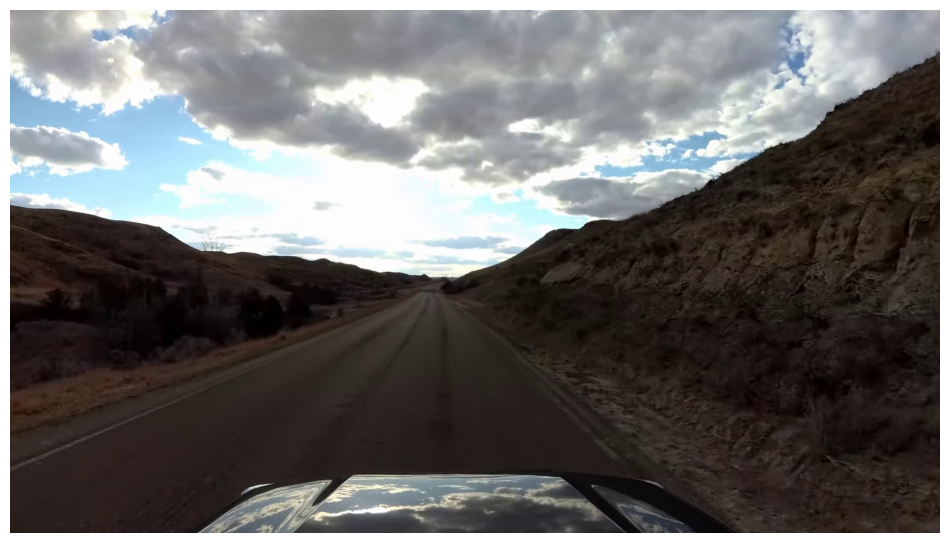

C:\Users\18438\AppData\Local\Temp\ipykernel_17952\1313530416.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_boxes=torch.tensor(boxes),


Loss: 0.0
Showing sample 1: C:\Users\18438\Downloads\TLD-YT-part1\CQtE8-EoOvQ\CQtE8-EoOvQ-part3\000001486.jpg


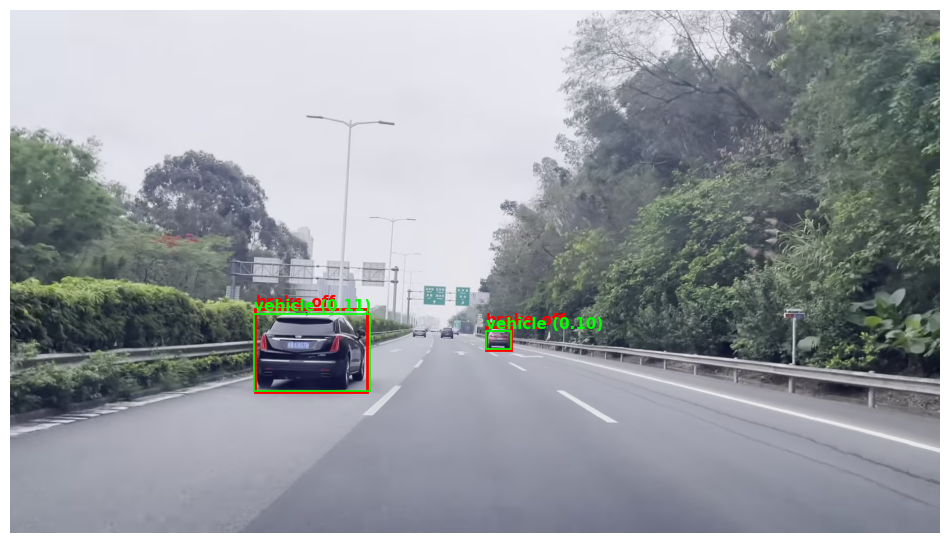

Loss: 3.746907629831192
Showing sample 2: C:\Users\18438\Downloads\TLD-YT-part2\DSIEIdJJ6CQ\DSIEIdJJ6CQ-part4\000002070.jpg


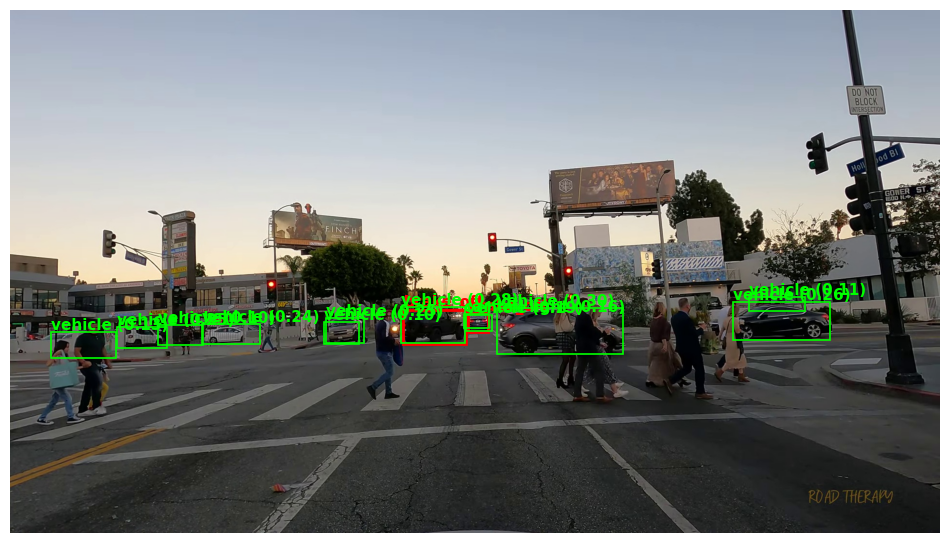

Loss: 3.643089365506671
Showing sample 3: C:\Users\18438\Downloads\TLD-YT-part1\ClJDi834PMM\ClJDi834PMM-part3\000001201.jpg


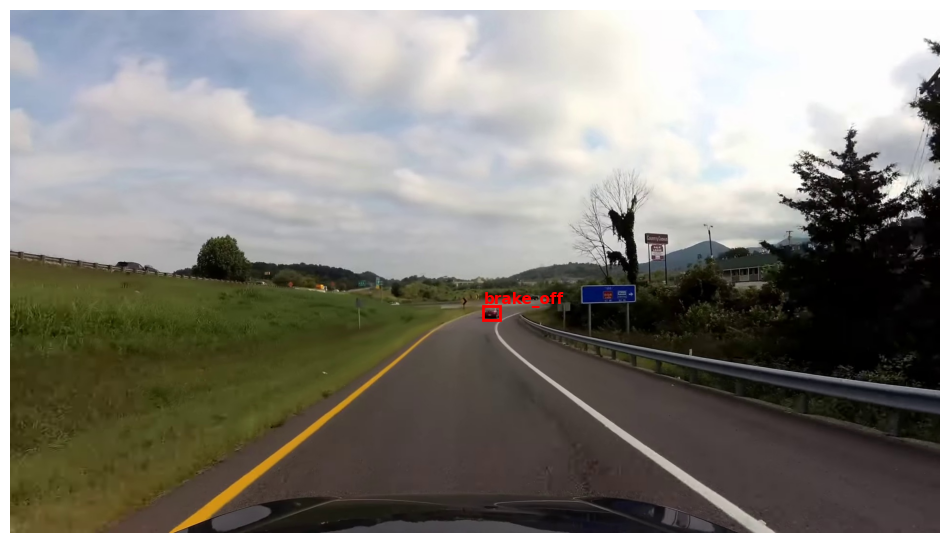

Loss: 14.426950408889635
Showing sample 4: C:\Users\18438\Downloads\TLD-YT-part1\C8vdEnP8pH8\C8vdEnP8pH8-part4\000001379.jpg


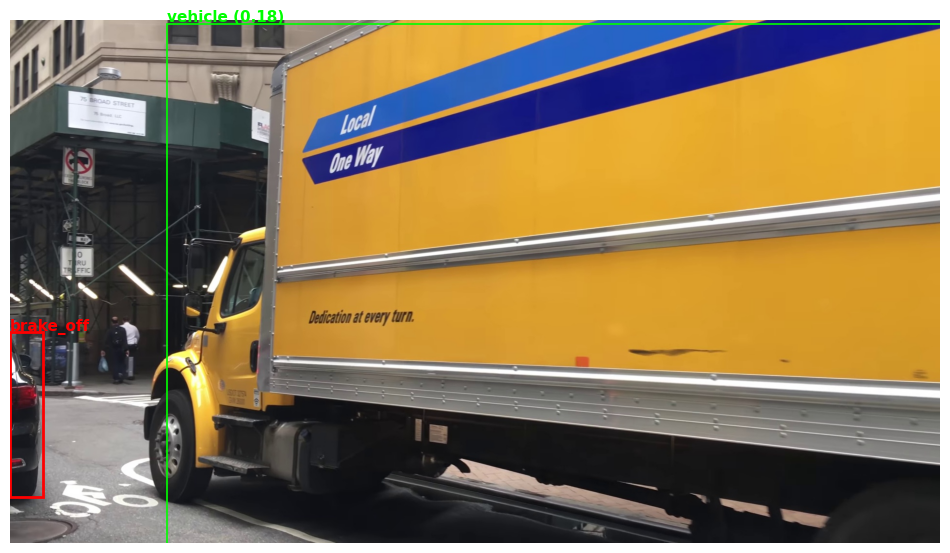

Loss: 4.06922584417953


In [103]:
for i in range(5):
    sample = samples[random.randint(0, len(samples) - 1)]
    print(f"Showing sample {i}: {sample['image_path']}")
    visualize_prediction(sample["image_path"], sample["objects"], draw=True)



Where does OWL-ViT fail in this safety-critical scenario?
